In [1]:
from IPython.display import display, Markdown
import numpy as np
def set_frame_style(df, caption=""):
    random_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap=random_list[np.random.randint(1,17)]).set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Brown'),
        ('font-size', '20px'),
        ('font-weight','bold')
    ]}])

# 
<center><font size = 2><span style="color:#F5F5E6"> <p style="background-color:#892743;font-family:courier;color:#FFFFFF;font-size:200%;text-align:center;border-radius:5px 5px;padding : 2px">Upvote if you find it useful👆 </p>   </span></font></center> 

<center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Table of contents </p>   </span></font></center> 

<a id="toc"></a>
- [About the dataset](#1)
    - [1.1 Dataset Description](#1.1)
- [2. Importing the data](#2)
- [3. Exploratory Data Analysis](#3)
    - [3.1 Distribution of Features](#3.1)
- [4. Preprocessing](#4)
    - [4.1 RobustScaler](#4.1)
    - [4.2 One Hot Encoding the columns](#4.2)
    - [4.3 Joining the columns after scaling and one-hot encoding](#4.3)
    - [4.4 Tomek Links : Downsampling for getting balanced dataset](#4.4)   
- [5. Model Training](#5)
- [6. Model Inference](#6)

# <a id="1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">About the dataset </p>   </span></font></center> 


    
- Several factors had been proposed to identify smokers who had a better chance of quitting, including the level of nicotine dependence, exhaled carbon monoxide (CO) concentration, cigarette amount per day, the age at smoking initiation, previous quit attempts, marital status, emotional distress, temperament and impulsivity scores, and the motivation to stop smoking. 

    
- However, individual use of these factors for prediction could lead to conflicting results that were not straightforward enough for the physicians and patients to interpret and apply.

    
- Providing a `prediction model` might be a favorable way to understand the chance of quitting smoking for each individual smoker. Health outcome prediction models had been developed using methods of machine learning over recent years.


    


![](https://th.bing.com/th/id/OIG.Xq0b_yfUUK5MAhtqbrGO?pid=ImgGn)

# <a id="1.1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 5px">Dataset Description </p>   </span></font></center> 


### Columns in the Dataset:


* age : 5-years gap
* height(cm)
* weight(kg)
* waist(cm) : Waist circumference length
* eyesight(left)
* eyesight(right)
* hearing(left)
* hearing(right)
* systolic : Blood pressure
* relaxation : Blood pressure
* fasting blood sugar
* Cholesterol : total
* triglyceride
* HDL : cholesterol type
* LDL : cholesterol type
* hemoglobin
* Urine protein
* serum creatinine
* AST : glutamic oxaloacetic transaminase type
* ALT : glutamic oxaloacetic transaminase type
* Gtp : γ-GTP
* dental caries
* smoking



>- ####  Target Variable : `smoking` : to predict the probability of smoking based on the given bio-signals (Remaining Columns)
>- #### Metric of Evaluation :  ROC-AUC

# <a id="2"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Importing the data </p>   </span></font></center> 

In [2]:
import pandas as pd
train_df = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
only_train_df = train_df.copy()
test_df = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
original_train_df = pd.read_csv('/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv')
train_df= train_df.drop(['id'],axis=1)
train_df = pd.concat([train_df, original_train_df]).sample(frac=1)
y = train_df['smoking']
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198240 entries, 847 to 15876
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 non-null  int64  
 15  hemoglobin           

In [3]:
def create_extra_features(df):
    # order the ears
    best = np.where(df['hearing(left)'] < df['hearing(right)'], 
                    df['hearing(left)'],  df['hearing(right)'])
    worst = np.where(df['hearing(left)'] < df['hearing(right)'], 
                     df['hearing(right)'],  df['hearing(left)'])
    df['hearing(left)'] = best - 1
    df['hearing(right)'] = worst - 1
    
    # order the eyes - eyesight is worst to best, and 9+ should be worst!
    df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
    df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
    best = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                    df['eyesight(left)'],  df['eyesight(right)'])
    worst = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                     df['eyesight(right)'],  df['eyesight(left)'])
    df['eyesight(left)'] = best
    df['eyesight(right)'] = worst
    ##
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    df['HDL'] = np.clip(df['HDL'], 0, 110)
    df['LDL'] = np.clip(df['LDL'], 0, 200)
    df['ALT'] = np.clip(df['ALT'], 0, 150)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)    

create_extra_features(train_df)
create_extra_features(test_df)

In [4]:
train_df.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
847      45         155          50       78.0             0.8   
30178    40         175          80       94.0             1.0   
34944    45         170          80       96.0             1.0   
4952     40         165          70       88.0             1.5   
111149   25         170          65       78.0             1.2   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
847                 1.2              0               0       120          80   
30178               1.0              0               0       122          72   
34944               1.5              0               0       135          85   
4952                1.5              0               0       134          84   
111149              1.5              0               0       126          70   

        ...  HDL  LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  \
847     ...   41  131        13.4              1               0.6   23   15   
30178   ...   51  110        15.5              1               0.9   15   22   
34944   ...   66  121        15.0              1               1.0   28   41   
4952    ...   58  134        15.9              1               0.9   21   14   
111149  ...   65   75        15.3              1               0.9   25   18   

        Gtp  dental caries  smoking  
847      14              0        0  
30178    32              1        0  
34944    62              1        1  
4952     14              0        1  
111149   17              0        1  

[5 rows x 23 columns]

In [5]:
test_id = test_df['id']

In [6]:
set_frame_style(train_df.describe())

In [7]:
set_frame_style(train_df.head())

In [8]:
set_frame_style(pd.DataFrame(train_df.nunique()),"Total Unique values in each column")

> ###  - No missing/null values in any of the columns
> ###  - hearing(left), hearing(right), Urine protein, dental caries can be one hot encoded

In [9]:
train_df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

> ### Storing the categorical and numerical columns separately for different operations

In [10]:
train_to_scale = train_df.drop(['hearing(left)', 'hearing(right)', 'Urine protein','dental caries', 'smoking'],axis =1)
train_to_ohe = train_df[['hearing(left)', 'hearing(right)', 'Urine protein','dental caries']]
test_to_scale = test_df.drop(['id','hearing(left)', 'hearing(right)', 'Urine protein','dental caries'],axis =1)
test_to_ohe = test_df[['hearing(left)', 'hearing(right)', 'Urine protein','dental caries']]

# <a id="3"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">EDA </p>   </span></font></center> 

> ### Let's see how many smoking individuals v/s non-smoking individuals

In [11]:
original_train_df['smoking'].value_counts()

smoking
0    24666
1    14318
Name: count, dtype: int64

In [12]:
import plotly.express as px
import plotly.graph_objects as go

colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)',
             'rgb(175, 49, 35)', 'rgb(36, 73, 147)']
cafe_colors =  ['rgb(146, 123, 21)', 'rgb(177, 180, 34)', 'rgb(206, 206, 40)',
            'rgb(175, 51, 21)', 'rgb(35, 36, 21)']

def pie_plot(train_df,colors,text):

    fig = go.Figure(data=[go.Pie(labels=['non-smoker','smoker'],values =train_df['smoking'].value_counts(),marker_colors=colors),
                        ])

    fig.update_traces(marker= dict(line=dict(color='#001000', width=2.5)))
    fig.update_layout(title = f'Target Variable Distribution for the {text}')
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")
    fig.show()
    del fig

pie_plot(only_train_df,colors,'Synthetic Data')
pie_plot(original_train_df,cafe_colors,'Original Data')



 > ### Synthetic data is somewhat more balanced than the original one

# <a id="3.1"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Distributions of Features </p>   </span></font></center> 

> ### Here, all columns have non-object data type

In [13]:
from plotly.subplots import make_subplots
columns = list(train_df.columns)

def feature_distributions(train_df):
    fig = make_subplots(rows=int(len(columns)/2), cols=2,subplot_titles=columns[:-1])
    count = 0
    for row in range(int(len(columns)/2)) : 
        for col in range(2):

            fig.add_trace(go.Violin(x=train_df[columns[-1]], y=train_df[columns[count]]), row=row + 1, col=col + 1)
            count +=1


    fig.update_layout(height=2600, width=1000, title_text="Feature Distribution for non-smokers vs smokers",showlegend=False)

    return fig

fig_1 = feature_distributions(original_train_df)
# fig_2 = feature_distributions(only_train_df)
fig_1.show()
del fig_1

> ### Observing the kde part of the Violin plot, most of them appear skewed

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# pair_plot_cols=[f for f in columns if train_df[f].nunique()>100]
# print(pair_plot_cols)
# sns.set(font_scale=1)
# plt.figure(figsize=(18, 10))
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(data=train_df, vars=pair_plot_cols,diag_kind='kde', 
#         kind='scatter', palette='muted', 
#         plot_kws={'s': 20}, hue='smoking')
# plt.show()


In [15]:
from prettytable import PrettyTable
from itertools import combinations

correlation_matrix = train_to_scale.corr()


table = PrettyTable()
table.field_names = ["Column 1", "Column 2", "Correlation"]


for col1, col2 in combinations(correlation_matrix.columns, 2):
    correlation = correlation_matrix.at[col1, col2]
    table.add_row([col1, col2, f"{correlation:.2f}"])
table.sortby = "Correlation"

print(table)


+---------------------+---------------------+-------------+
|       Column 1      |       Column 2      | Correlation |
+---------------------+---------------------+-------------+
|     Cholesterol     |   serum creatinine  |    -0.00    |
|    eyesight(left)   |         AST         |    -0.00    |
| fasting blood sugar |         LDL         |    -0.00    |
|    eyesight(left)   |     Cholesterol     |    -0.01    |
|   eyesight(right)   |     Cholesterol     |    -0.01    |
|    eyesight(left)   |         LDL         |    -0.02    |
|   eyesight(right)   |         LDL         |    -0.02    |
|         age         |     triglyceride    |    -0.03    |
|         age         |         Gtp         |    -0.04    |
|         age         |      waist(cm)      |    -0.04    |
|   eyesight(right)   |       systolic      |    -0.04    |
|    eyesight(left)   |         HDL         |    -0.05    |
|    eyesight(left)   |       systolic      |    -0.05    |
|   eyesight(right)   |         HDL     

> ### Many of them are highly positively and negatively correlated

# <a id="4"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Preprocessing</p>   </span></font></center> 

## <a id="4.1"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:200%;text-align:center;border-radius:5px 5px;padding : 2px">Robustscaler</p>   </span></font></center> 
> ###  It focuses only on the IQR for scaling unless specified/changed

In [16]:
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()


scaled_train = pd.DataFrame(sc.fit_transform(train_to_scale),columns = train_to_scale.columns)
scaled_test = pd.DataFrame(sc.transform(test_to_scale),columns = test_to_scale.columns)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



In [17]:
set_frame_style(scaled_train.head())

### <a id="4.2"> <center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:200%;text-align:center;border-radius:5px 5px;padding : 2px">One Hot Encoding the categorical columns</p>   </span></font></center> 


In [18]:
train_to_ohe.columns

Index(['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'], dtype='object')

In [19]:
ohe_train = pd.get_dummies(train_to_ohe, columns = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'])
ohe_test  = pd.get_dummies(test_to_ohe, columns = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'])

set_frame_style(ohe_train.head())

In [20]:
for i in ohe_train.columns : 
    ohe_train[i] = ohe_train[i].apply(lambda x :0.9 if x ==1 else 0.1)

In [21]:
ohe_train

hearing(left)_0  hearing(left)_1  hearing(right)_0  hearing(right)_1  \
847                 0.9              0.1               0.9               0.1   
30178               0.9              0.1               0.9               0.1   
34944               0.9              0.1               0.9               0.1   
4952                0.9              0.1               0.9               0.1   
111149              0.9              0.1               0.9               0.1   
...                 ...              ...               ...               ...   
105170              0.9              0.1               0.9               0.1   
130020              0.9              0.1               0.9               0.1   
3298                0.9              0.1               0.9               0.1   
32644               0.9              0.1               0.9               0.1   
15876               0.9              0.1               0.9               0.1   

        Urine protein_1  Urine protein_2  Urine protein_3  Urine protein_4  \
847                 0.9              0.1              0.1              0.1   
30178               0.9              0.1              0.1              0.1   
34944               0.9              0.1              0.1              0.1   
4952                0.9              0.1              0.1              0.1   
111149              0.9              0.1              0.1              0.1   
...                 ...              ...              ...              ...   
105170              0.9              0.1              0.1              0.1   
130020              0.9              0.1              0.1              0.1   
3298                0.9              0.1              0.1              0.1   
32644               0.9              0.1              0.1              0.1   
15876               0.9              0.1              0.1              0.1   

        Urine protein_5  Urine protein_6  dental caries_0  dental caries_1  
847                 0.1              0.1              0.9              0.1  
30178               0.1              0.1              0.1              0.9  
34944               0.1              0.1              0.1              0.9  
4952                0.1              0.1              0.9              0.1  
111149              0.1              0.1              0.9              0.1  
...                 ...              ...              ...              ...  
105170              0.1              0.1              0.9              0.1  
130020              0.1              0.1              0.9              0.1  
3298                0.1              0.1              0.9              0.1  
32644               0.1              0.1              0.1              0.9  
15876               0.1              0.1              0.9              0.1  

[198240 rows x 12 columns]

## <a id="4.3"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:200%;text-align:center;border-radius:5px 5px;padding : 2px">Joining the columns after scaling and one-hot encoding</p>   </span></font></center> 


In [22]:
ohe_train = ohe_train.reset_index(drop = True)
ohe_test = ohe_test.reset_index(drop = True)
ohe_train.head()

hearing(left)_0  hearing(left)_1  hearing(right)_0  hearing(right)_1  \
0              0.9              0.1               0.9               0.1   
1              0.9              0.1               0.9               0.1   
2              0.9              0.1               0.9               0.1   
3              0.9              0.1               0.9               0.1   
4              0.9              0.1               0.9               0.1   

   Urine protein_1  Urine protein_2  Urine protein_3  Urine protein_4  \
0              0.9              0.1              0.1              0.1   
1              0.9              0.1              0.1              0.1   
2              0.9              0.1              0.1              0.1   
3              0.9              0.1              0.1              0.1   
4              0.9              0.1              0.1              0.1   

   Urine protein_5  Urine protein_6  dental caries_0  dental caries_1  
0              0.1              0.1              0.9              0.1  
1              0.1              0.1              0.1              0.9  
2              0.1              0.1              0.1              0.9  
3              0.1              0.1              0.9              0.1  
4              0.1              0.1              0.9              0.1

In [23]:
scaled_train  = scaled_train.reset_index(drop =True)
scaled_test  = scaled_test.reset_index(drop =True)

In [24]:
y = y.reset_index(drop = True)

In [25]:
X_train = pd.concat([ohe_train,scaled_train,y],axis =1)
test_df = pd.concat([ohe_test,scaled_test],axis =1)
set_frame_style(X_train.head())

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198240 entries, 0 to 198239
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   hearing(left)_0      198240 non-null  float64
 1   hearing(left)_1      198240 non-null  float64
 2   hearing(right)_0     198240 non-null  float64
 3   hearing(right)_1     198240 non-null  float64
 4   Urine protein_1      198240 non-null  float64
 5   Urine protein_2      198240 non-null  float64
 6   Urine protein_3      198240 non-null  float64
 7   Urine protein_4      198240 non-null  float64
 8   Urine protein_5      198240 non-null  float64
 9   Urine protein_6      198240 non-null  float64
 10  dental caries_0      198240 non-null  float64
 11  dental caries_1      198240 non-null  float64
 12  age                  198240 non-null  float64
 13  height(cm)           198240 non-null  float64
 14  weight(kg)           198240 non-null  float64
 15  waist(cm)        

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   hearing(left)_0      106171 non-null  bool   
 1   hearing(left)_1      106171 non-null  bool   
 2   hearing(right)_0     106171 non-null  bool   
 3   hearing(right)_1     106171 non-null  bool   
 4   Urine protein_1      106171 non-null  bool   
 5   Urine protein_2      106171 non-null  bool   
 6   Urine protein_3      106171 non-null  bool   
 7   Urine protein_4      106171 non-null  bool   
 8   Urine protein_5      106171 non-null  bool   
 9   Urine protein_6      106171 non-null  bool   
 10  dental caries_0      106171 non-null  bool   
 11  dental caries_1      106171 non-null  bool   
 12  age                  106171 non-null  float64
 13  height(cm)           106171 non-null  float64
 14  weight(kg)           106171 non-null  float64
 15  waist(cm)        

In [28]:
X_train['smoking'].value_counts()

smoking
0    114269
1     83971
Name: count, dtype: int64

## <a id="4.4"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:200%;text-align:center;border-radius:5px 5px;padding : 2px">Tomek Links :  Downsampling for getting balanced dataset</p>   </span></font></center> 
> ### - Tomek links are pairs of data points where each point is from a different class, and the distance between them is less than or equal to a specified threshold
> ### - Removing data points that are part of Tomek links effectively trims the boundary of the majority class, making it more distinct from the minority class. This can lead to a better separation between the classes and improved model performance

In [29]:
from imblearn.under_sampling import TomekLinks

y = X_train[['smoking']]
X = X_train.drop('smoking',axis =1)
    
def tomek_links (X,y) : 
    '''Tomek Links are pairs of instances, one from the majority class and one from the minority class,
    that are very close to each other in the feature space. They are used in the context of dealing with
    imbalanced datasets to help balance the class distribution. The key idea is to 
    identify and remove those majority class instances that are near the minority class instances'''

    tl = TomekLinks(sampling_strategy='auto')

    X_resampled, y_resampled = tl.fit_resample(X, y)
    
    return X_resampled , y_resampled

X_resampled, y_resampled = tomek_links (X,y)



In [30]:
X_train = pd.concat([X_resampled,y_resampled], axis =1)
X_train['smoking'].value_counts()

smoking
0    105054
1     83971
Name: count, dtype: int64

## <a id="5"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Model Training</p>   </span></font></center> 

In [31]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

n_splits = 10

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
auc_scores = []
best_model = None
best_auc = 0.0
X = X_resampled
y = y_resampled

params = {'learning_rate': 0.019093223225293453, 
            'colsample_bytree': 0.21329015151846925,
            'colsample_bylevel': 0.9148369225084079,
            'subsample': 0.8831564960046078,
            'reg_alpha': 1.1496763786731952e-05, 
            'reg_lambda': 7.512814356733987e-07, 
            'max_depth': 12, 
            'n_estimators': 1950,
            'min_child_weight': 21,
          'tree_method': 'gpu_hist',
          'eval_metric': 'auc',
          'booster': 'gbtree',
          'n_jobs': -1,
          'verbosity': 0}

# Wrap the loop with tqdm for a progress bar
for train_index, test_index in tqdm(skf.split(X, y), total=n_splits):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBClassifier(**params)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

    if auc > best_auc:
        best_auc = auc
        best_model = model


100%|██████████| 10/10 [03:19<00:00, 19.94s/it]


In [32]:
print(best_auc)

0.8963519699500576


In [33]:
print(auc_scores)

[0.8900774496326082, 0.8897304547568399, 0.8946051197973693, 0.8953143727212504, 0.8945414237586771, 0.8921449020487757, 0.8963519699500576, 0.8929899093061329, 0.8910482977165356, 0.8909761634345396]


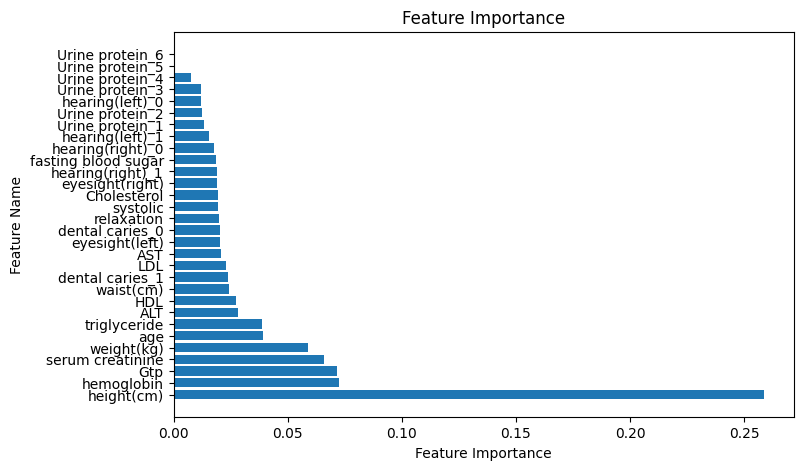

In [34]:
import matplotlib.pyplot as plt
feature_importances = best_model.feature_importances_
feature_names = X.columns 
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)
plt.figure(figsize=(8, 5))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.show()

## <a id="6"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Model Inference</p>   </span></font></center> 

In [35]:
y_pred = model.predict_proba(test_df)

In [36]:
y_pred[:,1].shape

(106171,)

In [37]:
test_id.shape

(106171,)

## <a id="6"><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#080743;font-family:courier;color:#FFFFFF;font-size:150%;text-align:center;border-radius:5px 5px;padding : 2px">Using submission files of public notebook for getting better public score</p>   </span></font></center> 

#### Ref : https://www.kaggle.com/code/alexryzhkov/lb-0-88048-simple-smoking-ensemble/notebook

In [42]:
s1 = pd.read_csv('/kaggle/input/smoking-lama-lightautoml-baseline/automl_submission.csv')
s2 = pd.read_csv('/kaggle/input/smoking-pseudo-subs/c4rl05v_sub_v12.csv')
s3 = pd.read_csv('/kaggle/input/pg-s3e24-brute-force-and-ignorance/submission.csv')
s4 = pd.read_csv('/kaggle/input/ps3e24-eda-feature-engineering-ensemble/submission.csv')
subs = s1[['id']]
subs['88105'] = s4['smoking'].values
subs['88028'] = s3['smoking'].values
subs['87942'] = s2['smoking'].values
subs['87858'] = s1['smoking'].values
subs['my_pred'] = y_pred[:,1]
subs.drop('id', axis = 1).corr()
subs.head()

id     88105     88028     87942     87858   my_pred
0  159256  0.636136  0.618684  0.639060  0.677993  0.687766
1  159257  0.235648  0.276356  0.141078  0.143294  0.216070
2  159258  0.371664  0.375030  0.391667  0.302239  0.264424
3  159259  0.016796  0.016780  0.014893  0.011585  0.016527
4  159260  0.675861  0.694244  0.662592  0.711751  0.737920

In [64]:
s1['smoking'] = (0.8 * s4['smoking'] + 
                 0.2 * (0.4 * s2['smoking'] + 
                        0.2 * s1['smoking'] + 0.4*y_pred[:,1]) )



In [61]:
s1

id   smoking
0       159256  0.653084
1       159257  0.213864
2       159258  0.357186
3       159259  0.016492
4       159260  0.691904
...        ...       ...
106166  265422  0.643954
106167  265423  0.589922
106168  265424  0.501096
106169  265425  0.086077
106170  265426  0.029846

[106171 rows x 2 columns]

In [62]:
# submission_df = pd.DataFrame()
# submission_df['id'] = test_id
# submission_df['smoking'] = y_pred[:,1]
# submission_df.head()

In [63]:
s1.to_csv('submission.csv',index = False)